# Natural Disaster tweet classification 
Everyday, there are various environmental/natural disasters that occur around the world. The speed of event and location identification has always been a challenge. Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, disaster relief organizations and news agencies have been paying more attention to this medium to in order programatically monitor for these events. The objective of this project is to classify tweets that are about real disasters and which one’s aren’t from a hand classified dataset on [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview) 

In [1]:
import nltk 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV 
from nltk.tokenize import punkt  
from nltk.corpus import stopwords 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
!pip install contractions
import contractions 
import string
import seaborn as sns 

#### Load and explore data

In [2]:
pd.set_option('display.max_colwidth',100)
# Load training set 
raw_ = pd.read_csv('text-data/train.csv')
raw_.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#### Data Exploration 


In [3]:
raw_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
raw_.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
raw_['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# Exploring what the unique keywords and locations are 
non_null_kw = raw_.keyword.notnull()
non_null_loc = raw_.location.notnull()
raw_['keyword'][non_null_kw].unique()[:30]

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags'], dtype=object)

In [7]:
raw_['location'][non_null_loc].unique()[:30]

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA'], dtype=object)

In [8]:
raw_[raw_['keyword'].notnull()][150:160]

,id,keyword,location,text,target
181,260,ambulance,Mumbai,If I get run over by an ambulance am I lucky? #justsaying #randomthought,0
182,261,ambulance,NaN,#news Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/bFeS5tWBzt #t...,1
183,262,ambulance,Amsterdam,http://t.co/7xGLah10zL Twelve feared killed in Pakistani air ambulance helicopter crash http://t...,1
184,263,ambulance,"Swindon,England",@TanSlash waiting for an ambulance,0
185,264,ambulance,NaN,@fouseyTUBE you ok? Need a ambulance. Hahahah that was good! http://t.co/ZSbErqNN9n,0
186,265,ambulance,Happily Married with 2 kids,AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/q8I...,0
187,266,ambulance,NaN,Pakistan air ambulance helicopter crash kills nine http://t.co/8E7rY8eBMf,1
188,267,ambulance,"Williamstown, VT",@TheNissonian @RejectdCartoons nissan are you ok do you need medical assistance i can call an am...,0
189,268,ambulance,"North Carolina, USA",EMS1: NY EMTs petition for $17 per hour Û÷minimum wageÛª http://t.co/4oa6SWlxmR #ems #paramedi...,0
190,269,ambulance,NaN,http://t.co/FCqmKFfflW Twelve feared killed in Pakistani air ambulance helicopter crash http://t...,1


Looks like there are 2533 and 61 null entries in the location and keyword columns respectively. When we look at the non-null entries in the cell output above, we can see that there are some values that are mislabeled, eg. entry 186 Happily Married with 2 kids or are null values that have a country referenced in the text column, eg. entry 189 Pakistani, which can be used to backfill these null values. The other viable option would be to completely drop the two columns which would also work in this case. If the prediction accuracy is not good enough, we can try to incorporate these columns and try the classification task again.

In [9]:
def bin_target_modifier(df,target_col='',words=[]):
    '''for a given list of keywords, modify target column values in a dataframe '''
    for word in words:
        mislabeled_target_ind = df[df['text'].str.contains(word)].index.values
        for ind in mislabeled_target_ind:
            if df[target_col][ind] != 0:
                df[target_col][ind] = 0
    return 'Targets modified'
    

In [10]:
not_disaster_kw = ['suicide','war','drugs']
# Prior to splitting the training set, 
# it was discovered in a later cell that some targets were mislabeled as disasters
# It will be important to re-label these entries prior to splitting them into the train and test sets
bin_target_modifier(raw_,target_col='target',words=not_disaster_kw)

<ipython-input-9-921f30d1d30d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_col][ind] = 0


'Targets modified'

In [11]:
# split data into training and test 
X_train, X_test, y_train, y_test = train_test_split(raw_[['text']],raw_['target'],random_state=42)
print(X_train.shape, X_test.shape)
X_train[50:70]

(5709, 1) (1904, 1)


,text
1934,Next May I'll be free...from school from obligations like family.... Best of all that damn curfe...
5345,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu
6359,NTSB: Virgin Galactic crash caused by structural failure triggered when brakes unlocked early ht...
3882,Zouma has just absolutely flattened that guy ??
4756,Don't blink ?? won't see the Lightning take the W ?? http://t.co/D4c2iqiRnU
5062,anyway 2 me? Mateo just doesnt exist? Hes a mirage a pointless addition to our Generation. a hum...
1203,The greatest female beat boxer ever now but it's w/e... Save babies outta burning buildings on m...
2550,If Shantae doesn't get in Smash I will destroy my Wii U.\n#ShantaeForSmash #Shantae #ShantaeHalf...
969,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/...
1805,Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa


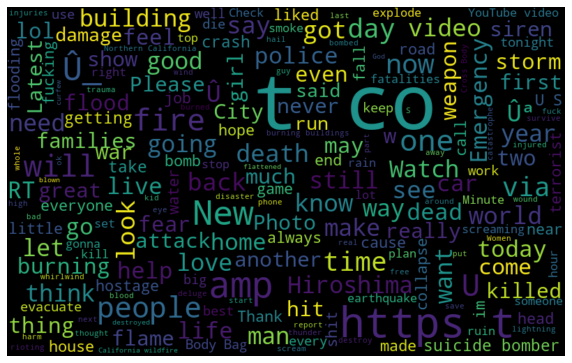

In [12]:
from wordcloud import WordCloud
# Generate word cloud
all_words = ' '.join([text for text in X_train['text']])
wordcloud = WordCloud(width=800, height = 500, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


From the wordcloud above, we can see that there are a stopwords, unicode characters, hyperlink components to name a few of the words that constitute as noise and will need to be cleaned up in order to get rid of any characters that wouldn't help in our classification task. 

#### Data preprocessing and manipulation 


In [13]:
# create a data cleaning function that tokenizes, 
# removes english stopwords and punctuations and returns tokenized text in lowercase 

def clean_text_lm(text):
    '''Removes punctuations and stopwords and returns lowercase tokenized text for input text and pattern'''
    
    # expand contracted sentences
    doc = contractions.fix(text) 
    eng_stop = stopwords.words('english') # english stopwords
    wn = nltk.WordNetLemmatizer() # Instantiate word lemmatizer
    
    # match regex pattern and remove users, replace with empty string
    #  doc_nousr = re.sub(r'@[^\s]+',r'',doc)
    
    # remove any ascii symbols 
    doc_noascii= doc.encode("ascii", errors="ignore").decode()
    # remove any links
    doc_nourl = re.sub(r'(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',r'',doc_noascii)
    # remove any remaining special characters
    doc_nospchar = re.sub(r'^a-zA-Z\s\W+',r'',doc_nourl,re.I | re.A) 
    
    # remove punctuations from previous out
    doc_nopunct = ''.join([char for char in doc_nospchar if char not in string.punctuation])
    
    # convert text to lower case and strip white space if any
    doc_lower_nospc = doc_nopunct.lower().strip() 
    
    # lemmatize and store in list format
    lem_text = [wn.lemmatize(word) for word in re.split('\W+',doc_lower_nospc)] 
    #  removes any nonsensical words
    lem_text = [word for word in lem_text if len(word) > 2 and word != 'amp']
    
     # join list into string with no stopwords
    no_stop_docs = ' '.join([word for word in lem_text if word not in eng_stop])
    
    return no_stop_docs

# Vectorize the function to apply accross dataframe
cleaner = np.vectorize(clean_text_lm)

In [14]:
# store clean text in separate column in df
X_train['cleaned_text'] = cleaner(X_train[['text']])
X_train.head()

,text,cleaned_text
5151,@dicehateme @PuppyShogun This makes sense. Paper beats rock paper comes from wood so wood should...,dicehateme puppyshogun make sense paper beat rock paper come wood wood able support obliterate rock
6351,'@CatoInstitute: The causes of federal failure are deeply structural and they will not be easily...,catoinstitute cause federal failure deeply structural easily solved
3443,Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Look...,well chaning ipad screen fucking exploded glass went place look like job going need new one
7164,the war on drugs has turned the U.S. into a WAR zone.,war drug turned war zone
7037,Obama Declares Disaster for Typhoon-Devastated Saipan,obama declares disaster typhoondevastated saipan


In [15]:
# clean up text in test set
X_test['cleaned_text'] = cleaner(X_test[['text']])
X_test.head()

,text,cleaned_text
2644,So you have a new weapon that can cause un-imaginable destruction.,new weapon unimaginable destruction
2227,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons...,famping thing gishwhes got soaked deluge going pad tampon thx mishacollins
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool St...,georgegalloway galloway4mayor col police catch pickpocket liverpool
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. W...,aftershock back school kick great want thank everyone making possible great night
6845,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerab...,response trauma child addict develop defensive self one decrease vulnerability


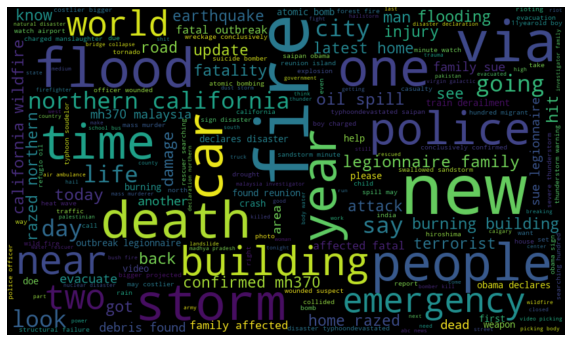

In [16]:
# Apply cleaning function on raw text
raw_['cleaned_text'] = cleaner(raw_['text'])

# Generate word cloud for text labeled as disasters
disaster_words = ' '.join(word for word in raw_['cleaned_text'][raw_['target']==1])
wordcloud = WordCloud(width=850, height=500, max_font_size=110).generate(disaster_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('images/disaster_wordcloud.jpg')

This word cloud shows us word frequency in tweets that are associated to disaster, the larger the text would indicate a higher frequency of the word being used. There are some words that shouldn't be associated to natural disasters for eg. suicide bomber, hiroshima, oil spills are disasters but their origins are not from a natural source. 
<br>
The cleaned text is now devoid of any special characters or stopwords, however its still not ready to be vectorized. The first action required is to tokenize the words, ie, converting the sentence into a list of words, and then, there can be many words that have a similar meaning such search, searching, searched, etc. I used a lemmatizer (WordNetLemmatizer) to correlate words with similar meaning and keeps the root words. 

#### Feature engineering
As we can see from prior modeling, the accuracy seems to be stagnant at ~77% even though the parameters were tuned using cross validation. Creating new features from the dataset might help with this issue. 

Utilized the guide on [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/) as a reference for this task.

##### Extracting basic NLP count based features 

In [17]:
def extract_basic_count_features(df,col_name=''):
    # Length of text 
    df['doc_len'] = df[col_name].apply(len)
    df['word_count'] = df[col_name].apply(lambda x: len(x.split()))
    # Number of caps per tweet 
    df['CAPS_len'] = df[col_name].apply(lambda x: 
                                       len([word for word in x.split() if word.isupper()])
                                      )
    df['sent_len'] = df[col_name].apply(lambda x: len(nltk.sent_tokenize(x)))
    df['hashtag_count'] = df[col_name].apply(lambda x: len(re.findall(r'(\#[A-Za-z0-9]*)',x)))
    df['unique_word_count'] = df[col_name].apply(lambda x: len(set(x.split())))
    return 'Basic count features extracted.'


Let's visualize what the count features look like and see if it will be useful in the classification task

In [18]:
extract_basic_count_features(raw_,'text')

'Basic count features extracted.'

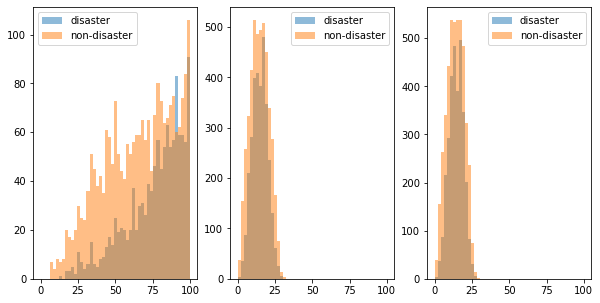

In [19]:
bins = np.linspace(0, 100, 50)

# create subplots, figsize to control size of the image
fig, ax = plt.subplots(1,3, figsize=(10,5)) 
# plt.subplot(1,3,1) # 1 line, 2 rows, index nr 1 (first position in the subplot)
ax[0].hist(raw_[raw_['target']==1]['doc_len'], bins, alpha=0.5, label='disaster')
ax[0].hist(raw_[raw_['target']==0]['doc_len'], bins, alpha=0.5, label='non-disaster')
ax[0].legend(loc='best')
# plt.subplot(1, 3, 2) 
ax[1].hist(raw_[raw_['target']==1]['word_count'], bins, alpha=0.5, label='disaster')
ax[1].hist(raw_[raw_['target']==0]['word_count'], bins, alpha=0.5, label='non-disaster')
ax[1].legend(loc='best')
# plt.subplot(1,3,3)
ax[2].hist(raw_[raw_['target']==1]['unique_word_count'], bins, alpha=0.5, label='disaster')
ax[2].hist(raw_[raw_['target']==0]['unique_word_count'], bins, alpha=0.5, label='non-disaster')
ax[2].legend(loc='best')

plt.show()

From the bar graphs above, we can see that it would seem like non-disaster tweets are longer than disaster tweets. However, from an observation earlier, there is a class imbalance in this dataset, where there are more non-disaster tweets compared to disaster tweets. This could be the reason for the observed higher frequency of non-disaster tweets in our visualizations.

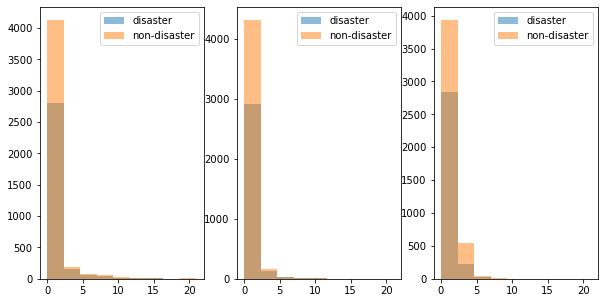

In [20]:
small_bins = np.linspace(0, 21, 10)
fig, ax = plt.subplots(1,3, figsize=(10,5)) 
# plt.subplot(1,3,1) # 1 line, 2 rows, index nr 1 (first position in the subplot)
ax[0].hist(raw_[raw_['target']==1]['CAPS_len'], small_bins, alpha=0.5, label='disaster')
ax[0].hist(raw_[raw_['target']==0]['CAPS_len'], small_bins, alpha=0.5, label='non-disaster')
ax[0].legend(loc='best')
# plt.subplot(1, 3, 2) 
ax[1].hist(raw_[raw_['target']==1]['hashtag_count'], small_bins, alpha=0.5, label='disaster')
ax[1].hist(raw_[raw_['target']==0]['hashtag_count'], small_bins, alpha=0.5, label='non-disaster')
ax[1].legend(loc='best')
# plt.subplot(1,3,3)
ax[2].hist(raw_[raw_['target']==1]['sent_len'], small_bins, alpha=0.5, label='disaster')
ax[2].hist(raw_[raw_['target']==0]['sent_len'], small_bins, alpha=0.5, label='non-disaster')
ax[2].legend(loc='best')
plt.show()

#### Generating features using sentiment analysis

Since we are dealing with disasters, we can try and derive the sentiment of each tweet based on the commonly used words that are associated to disasters such as death, hurricane, flood etc. 
NLTK conveniently has a library that can allow us to perform this kind of analysis. 


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\TerenceY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
def tweet_sentiments(df):
    '''Given dataframe, generate polarity scores for the given cleaned text column and 
    return list of polarity compound scores '''
    sent_analyze = SentimentIntensityAnalyzer()
    polar_ = np.vectorize(sent_analyze.polarity_scores)
    polar_list = [ val['compound'] for val in polar_(df['cleaned_text'])]
    return polar_list


In [23]:
raw_['polarity']=tweet_sentiments(raw_)
raw_.head()

,id,keyword,location,text,target,cleaned_text,doc_len,word_count,CAPS_len,sent_len,hashtag_count,unique_word_count,polarity
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive,69,13,1,1,1,13,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,38,7,0,2,0,7,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,resident asked shelter place notified officer evacuation shelter place order expected,133,22,0,2,0,20,0.0000
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfire evacuation order california,65,8,0,1,1,8,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfire pours school,88,16,0,1,2,15,0.0000


Now let's use these functions to derive features for our train and test sets 

In [24]:
extract_basic_count_features(X_train,'text')
X_train['polarity'] = tweet_sentiments(X_train)

train_meta_feats_col = X_train.columns[2:]
X_train_meta = X_train[train_meta_feats_col]
X_train_meta.head()

,doc_len,word_count,CAPS_len,sent_len,hashtag_count,unique_word_count,polarity
5151,136,22,0,2,0,21,-0.2960
6351,128,17,0,1,0,17,0.1882
3443,137,29,1,2,0,29,0.5574
7164,53,12,2,1,0,11,-0.8316
7037,53,6,0,1,0,6,-0.6249


In [25]:
extract_basic_count_features(X_test,'text')
X_test['polarity'] = tweet_sentiments(X_test)
test_meta_feats_col = X_test.columns[2:]
X_test_meta = X_test[test_meta_feats_col]
X_test_meta.head()

,doc_len,word_count,CAPS_len,sent_len,hashtag_count,unique_word_count,polarity
2644,66,11,0,1,0,11,-0.7096
2227,119,21,2,2,1,20,0.3612
5448,125,15,2,1,0,15,0.0000
132,114,21,1,3,0,20,0.9001
6845,105,17,0,2,0,17,-0.5574


#### Adding Bag of Words features 
This will create a simple vector space representational model for the unstructured text. It will represent each text document as a numerical vector where each dimension is a specific word from the corpus and the value would be its frequency in the document or weighted values.

Source: [TowardsDataScience](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41), [AnalyticsVidhya](https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640)

In [26]:
# Instantiate CountVectorizer, bag of words model
unigram_vec = CountVectorizer(analyzer = 'word',ngram_range = (1,1))

# fit and transform using bag of words model
train_cmatrix = unigram_vec.fit_transform(X_train['cleaned_text']).astype('float').toarray()

# convert count matrix to dataframe
train_cmatrix_df = pd.DataFrame(train_cmatrix, columns = unigram_vec.get_feature_names() )

# performing similar steps on test data
test_cmatrix = unigram_vec.transform(X_test['cleaned_text']).astype('float').toarray()
test_cmatrix_df = pd.DataFrame(test_cmatrix,columns = unigram_vec.get_feature_names())

train_cmatrix.shape, test_cmatrix.shape

((5709, 12970), (1904, 12970))

In [27]:
# range of uni- and bi-gram vectors 
uni_bigram_vec = CountVectorizer(analyzer = 'word',ngram_range = (1,2))
unibigram_train_cmatrix = uni_bigram_vec.fit_transform(X_train['cleaned_text']).astype('float').toarray()

# Test count matrix
unibigram_test_cmatrix = uni_bigram_vec.transform(X_test['cleaned_text']).astype('float').toarray()

unibigram_train_cmatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Train count matrix
bi_trigram_vec = CountVectorizer(analyzer = 'word',ngram_range = (2,3))
bi_trigram_train_cmatrix = bi_trigram_vec.fit_transform(X_train['cleaned_text']).astype('float').toarray()

# Test count matrix
bi_trigram_test_cmatrix = bi_trigram_vec.transform(X_test['cleaned_text']).astype('float').toarray()

bi_trigram_train_cmatrix.shape, bi_trigram_test_cmatrix.shape

((5709, 65634), (1904, 65634))

In [29]:
# merge meta features with count matrix using inner join
full_train_df = train_cmatrix_df.join(X_train_meta).fillna(0.0)
full_train_cmatrix = full_train_df.to_numpy()

full_test_df = test_cmatrix_df.join(X_test_meta).fillna(0.0)
full_test_cmatrix = full_test_df.to_numpy()
print("train: {}\n test: {}\n".format(full_train_cmatrix.shape,full_test_cmatrix.shape))
full_train_df.head()

train: (5709, 12977)
 test: (1904, 12977)



,005225,010156,010217,0104,010401,0106,012032,012624,015025,0306,...,zouma,zumiez,zzzz,doc_len,word_count,CAPS_len,sent_len,hashtag_count,unique_word_count,polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,38.0,7.0,0.0,2.0,0.0,7.0,-0.34
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,133.0,22.0,0.0,2.0,0.0,20.0,0.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,65.0,8.0,0.0,1.0,1.0,8.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,88.0,16.0,0.0,1.0,2.0,15.0,0.00


### Classification of tweets - Experiment 1

##### Logistic Regression
As mentioned earlier, we're trying to classify whether this is a natural disaster tweet or not. The outcome we're looking for is binary in nature. We can therefore, try using logistic regression as a classification algorithm. It can be used to predict a binary outcome based on a set of independent variables. The logistic regression classifier uses the weighted combination of the input features and passes them through a sigmoid function.

Source:[Analytics Vidhya](https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640),
[Career foundry](https://careerfoundry.com/en/blog/data-analytics/what-is-logistic-regression/)

In [30]:
from sklearn.linear_model import LogisticRegression

# Instantiate logistic regression 
lr = LogisticRegression(C=1, random_state=42, solver='liblinear')

#### Model training and evaluation

In [31]:
# fit the model

lr.fit(full_train_cmatrix,y_train)
# predictions
y_hat_lr = lr.predict(full_test_cmatrix)

# print results
print("Results of logistic regression as a classifier: \n", classification_report(y_test, y_hat_lr))
lr_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_hat_lr))
lr_conf_matrix

Results of logistic regression as a classifier: 
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1142
           1       0.77      0.69      0.73       762

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



,0,1
0,982,160
1,233,529


Interesting, based on the results, it seems like our first model seems to have done a surprisingly decent job at differentiating disaster from non-disaster tweets with <b>79%</b> accuracy using the bag-of-unigrams model and the meta features we had calculated prior to that.  


##### Ensemble Classifiers -- RandomForest 

In [108]:
# Instantiate classifier
rf_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
# fit the model 
rf_model = rf_clf.fit(full_train_cmatrix, y_train)
# predict on test 
y_hat_rf = rf_model.predict(full_test_cmatrix)

# evaluate model 
print("Results of RandomForest classifier: \n",classification_report(y_test, y_hat_rf))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat_rf),index=['non-disaster','disaster'])
print(confusion_)

Results of RandomForest classifier: 
               precision    recall  f1-score   support

           0       0.78      0.90      0.84      1142
           1       0.80      0.62      0.70       762

    accuracy                           0.79      1904
   macro avg       0.79      0.76      0.77      1904
weighted avg       0.79      0.79      0.78      1904

                 0    1
non-disaster  1025  117
disaster       288  474


From the results shown above, we can see that the accuracy is has not changed when compared to the logistic regression (LR) model's results and remains stubbornly at <b>79%</b>. However, if we compare the precision and recall scores to LR, we can see that RandomForest (RF) classifier did a slightly better job at correctly distinguishing the disaster tweets from the non-disaster ones. The confusion matrix provides a more granular view of how many true positive values did it correctly identify. 

#### Hyperparameter tuning 
While the performance using default parameters of the classifier yielded decent scoring in precision, recall and f1-score, we should try to see what would be configuration would provide the best score possible using the RandomForest classifier. To do this, we can try to use grid search cross validation to determine these parameters. However, my opinion is to not use this type of cross validation technique unless you already know what parameters you would like to limit this to, otherwise, it is best to avoid guessing what the best values. 

In [ ]:
# # Find best params using GridSearchCV
# params = {'criterion':['gini','entropy'],
#           'n_estimators':[50,100,150], 
#           'max_depth':[50,75,100,None]
#          }
# rf = RandomForestClassifier(random_state=42)
# rf_gs = GridSearchCV(rf ,param_grid = params ,cv = 5, scoring='accuracy', n_jobs=-1)
# rf_gs.fit(train_cmatrix,y_train)
# rf_grid_pred = rf_gs.predict(test_cmatrix)
# best_params = rf_gs.best_params_
# print("Best params: {}\n Best Score: {}".format(best_params,rf_gs.best_score_))
# print(classification_report(y_test,rf_grid_pred))


In [ ]:
%%time
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_param_grid = {'criterion':['gini','entropy'],
                 'n_estimators':np.arange(100, 2500, 100),
                 'max_features':['auto','log2','sqrt'],
                 'max_depth':np.arange(20, 500, 25)
                }
# Find best params using RandomizedgridsearchCV
rf_randomizedcv_roc_auc = RandomizedSearchCV(rf, 
                                        param_distributions=rf_param_grid,
                                        n_iter=3, 
                                        scoring="roc_auc", 
                                        verbose=1, 
                                        cv=5,
                                         n_jobs=-1)
rf_randomizedcv_roc_auc.fit(full_train_cmatrix,y_train)
print(rf_randomizedcv_roc_auc.best_score_)
print(rf_randomizedcv_roc_auc.best_estimator_)
best_rf_clf = rf_randomizedcv_roc_auc.best_estimator_



In [ ]:
y_hat = best_rf_clf.transform(full_test_cmatrix)
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat),index=['non-disaster','disaster'])
sns.heatmap(confusion_)

In [ ]:
# Rerun RF classifier with optimized parameters
rf_clf = RandomForestClassifier(random_state=42,verbose=1,n_jobs = -1)

# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat),index=['non-disaster','disaster'])
print(confusion_)

In [ ]:
# uni-bigram model 
rf_model_unibigram = rf_clf.fit(unibigram_train_cmatrix,y_train)
unibigram_y_hat = rf_model_unibigram.predict(unibigram_test_cmatrix)
print(classification_report(y_test, unibigram_y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, unibigram_y_hat),index=['non-disaster','disaster'])
print(confusion_)

In [ ]:
# bi-trigram model 
rf_model_bitrigram = rf_clf.fit(bi_trigram_train_cmatrix,y_train)
bi_trigram_y_hat = rf_model_unibigram.predict(bi_trigram_test_cmatrix)
print(classification_report(y_test, bi_trigram_y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, bi_trigram_y_hat),index=['non-disaster','disaster'])
print(confusion_)

In [ ]:
#Calculate the y_score
rf_y_score = rf_model_unibigram.predict_proba(test_cmatrix)

from sklearn.preprocessing import label_binarize
#Binarize the output
rf_y_test_bin = label_binarize(y_test, classes=[0,1])
n_classes = rf_y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#create ROC curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(rf_y_test_bin[:, i], rf_y_score[:, i])
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
    print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='maroon', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()



Drew inspiration for code from [laurenlizz22](https://laurenliz22.github.io/roc_curve_multiclass_predictions_random_forest_classifier) 

##### Analysis of results
Our optimized model was able to distinguish disaster from non-disaster tweets with ~<b>77%</b> accuracy.
<br>
From the confusion matrix, there seems to be a marked difference in the classification of true negatives and positives. However, we also see any improvements in the precision, recall or f1-scores when compared to the default model. We also notice a drastic difference in recall scores between the 0 (non-disaster) and 1 (disaster) labels. One reason might because of the class imbalance in the training dataset. 
<br>
It might be worthwhile to look into other classifiers as well as adding features to improve our classification. 


#### Using TF-IDF vectorizer and XGB classifier 


In [ ]:
gb = GradientBoostingClassifier(random_state=42)
tf_vect = TfidfVectorizer(analyzer=clean_text_lm, min_df=2, max_df=0.9)
train_tfidf_matrix = tf_vect.fit_transform(X_train['cleaned_text']).toarray()
test_tfidf_matrix = tf_vect.transform(X_test['cleaned_text']).toarray()
gb.fit(train_tfidf_matrix,y_train)
gb_y_hat = gb.predict(test_tfidf_matrix)
print(classification_report(y_test, gb_y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, gb_y_hat),index=['non-disaster','disaster'])
print(confusion_)

In [ ]:
gbm_param_grid = {
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50)
}
# gb_steps=[('tf',tf_vect),('XGB',gb)]
# gb_pipeline = Pipeline(steps=gb_steps)
# gb_pipeline.fit(train_tfidf_matrix,y_train)
gb_randomizedcv_roc_auc = RandomizedSearchCV(gb, 
                                        param_distributions=gbm_param_grid,
                                        n_iter=1, 
                                        scoring="roc_auc", 
                                        verbose=1, 
                                        cv=5,
                                         n_jobs=-1)
gb_randomizedcv_roc_auc.fit(train_tfidf_matrix,y_train)
grid_pred_gbm = gb_randomizedcv_roc_auc.predict(test_tfidf_matrix)
best_params_gbm = gb_randomizedcv_roc_auc.best_params_
print("Best params: {}\n Best Score: {}".format(best_params_gbm,randomizedcv_roc_auc.best_score_))
print(classification_report(y_test,grid_pred_gbm))